In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')


In [32]:
import signale.tools as tools
import numpy as np
import cPickle as pkl
from mtspec import mtspec, sine_psd
from mtspec.util import _load_mtdata
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py
from scipy.signal import argrelmax
import seaborn as sns
%matplotlib 

Using matplotlib backend: Qt4Agg


/home/chenani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [35]:
lfpS = pkl.load(open('/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3903/LinearTrack_05-12-16_Day4/01-sleep1/CSC6-pre.lfp','rb'))
#lfpR = pkl.load(open('/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3661/LinearTrack_03-03-15Day1/02-begin1/CSC02.lfp','rb'))

In [7]:

#inline

plt.style.use("ggplot")


NN = np.random.randint(1,lfpS.signal_white.size-2048)
data = lfpS.signal_white[NN:NN+2048]#_load_mtdata('PASC.dat.gz')
plt.figure(figsize=[30,20])
plt.subplot(311)
plt.plot(data, color='black')
plt.xlim(0, len(data))

spec, freq = mtspec(data, 1.0, 1.5, number_of_tapers=1,nfft=4096)
freq*=2e3
print 1,spec[:5].mean(),spec[6:11].mean()
plt.subplot(323)
plt.plot(freq, spec, color='black')
#plt.yscale('log')
plt.xlim(freq[0], freq[41])
plt.text(x=0.5, y=0.85, s="Single Taper",
         transform=plt.gca().transAxes, ha="center")

spec, freq = mtspec(data, 1.0, 2, number_of_tapers=5,nfft=4096)
freq*=2e3
print 2,spec[:5].mean(),spec[6:11].mean()
plt.subplot(324)
plt.plot(freq, spec, color='black')
plt.xlim(freq[0], freq[41])
#plt.yscale('log')
plt.text(x=0.5, y=0.85, s="5 Tapers Multitaper",
         transform=plt.gca().transAxes, ha="center")

spec, freq = sine_psd(data, 1.0,number_of_tapers=5,number_of_iterations=1)
freq*=2e3
print 3,spec[:5].mean(),spec[6:11].mean()
plt.subplot(325)
plt.plot(freq, spec, color='black')
plt.xlim(freq[0], freq[41])
#plt.yscale('log')
plt.text(x=0.5, y=0.85, s="Sine Multitaper",
         transform=plt.gca().transAxes, ha="center")

spec, freq = mtspec(data, 1.0, 1, number_of_tapers=5,quadratic=False,nfft=4096)
freq*=2e3
print 4,spec[:5].mean(),spec[6:11].mean()
plt.subplot(326)
plt.plot(freq, spec, color='black')
plt.xlim(freq[0], freq[41])
#plt.yscale('log')
plt.text(x=0.5, y=0.85, s="Quadratic Multitaper",
         transform=plt.gca().transAxes, ha="center")

plt.tight_layout()
plt.show()

Using matplotlib backend: Qt4Agg
1 2661.03 4043.33
2 3645.71 13024.3
3 6188.92 51836.5
4 3548.9 8983.7


In [8]:
def mySpecgram(sig,minFreq = None,maxFreq = None,overlap=None,
               windowSize= None,NFFT = None,Fs = None,method=None):
    if not overlap:
        overlap = 48
    kIdx = 0
    timeSlices = []
    timeCenters = []
    while kIdx < sig.size:
        #timeEdges = np.arange(0,Nbins*windowSize,windowSize)
        timeSlices.append([kIdx,kIdx+windowSize])
        kIdx += windowSize - overlap
    Pxx = []
    for item in timeSlices: 
        timeCenters.append((item[0]+np.diff(item)/2)[0])
        data = sig[item[0]:item[1]]
        if data.size < windowSize:
            ddd = windowSize - data.size
            if ddd%2 ==0:
                data = np.lib.pad(data, (ddd/2,ddd/2), 'constant', constant_values=(0,0))
            else:
                data = np.lib.pad(data, (ddd/2,ddd/2+1), 'constant', constant_values=(0,0))
        spec, freqz = mtspec(data, 1.0, 1.5, number_of_tapers=5,quadratic=False,nfft=4096)
        freqz*=2e3
        Pxx.append(spec)
    Pxx = np.array(Pxx).T
    if not minFreq:
        minFreq = freqz.min()
    if not maxFreq:
        maxFreq = freqz.max()
    indexstart = np.where(freqz >= minFreq)[0][0]
    indexend   = np.where(freqz <= maxFreq)[0][-1]
    freqz = freqz[indexstart:indexend]
    Pxx = Pxx[indexstart:indexend]
    timeCenters = np.array(timeCenters)
    return timeCenters,freqz,Pxx


In [9]:
t,frq,Pxx = mySpecgram(lfpS.signal_white[:],windowSize=2048,overlap=10,minFreq=0.1,maxFreq=200)
#Pxx = np.clip(Pxx,Pxx.min(),Pxx.mean()+2*Pxx.std())
for idx in range(Pxx.shape[1]):
    Pxx[:,idx] /= Pxx[:,idx].std()
    Pxx[:,idx] -= Pxx[:,idx].mean()

In [10]:
f,ax=plt.subplots(1,1,figsize=[25,15])
ax.pcolor(t/2,frq,Pxx,cmap='viridis')
#plt.colorbar()

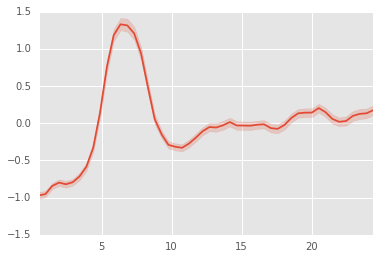

In [75]:
import seaborn as sns
sns.tsplot(Pxx[:,100:290].T,time=frq)

In [74]:
frq

array([  0.48828125,   0.9765625 ,   1.46484375,   1.953125  ,
         2.44140625,   2.9296875 ,   3.41796875,   3.90625   ,
         4.39453125,   4.8828125 ,   5.37109375,   5.859375  ,
         6.34765625,   6.8359375 ,   7.32421875,   7.8125    ,
         8.30078125,   8.7890625 ,   9.27734375,   9.765625  ,
        10.25390625,  10.7421875 ,  11.23046875,  11.71875   ,
        12.20703125,  12.6953125 ,  13.18359375,  13.671875  ,
        14.16015625,  14.6484375 ,  15.13671875,  15.625     ,
        16.11328125,  16.6015625 ,  17.08984375,  17.578125  ,
        18.06640625,  18.5546875 ,  19.04296875,  19.53125   ,
        20.01953125,  20.5078125 ,  20.99609375,  21.484375  ,
        21.97265625,  22.4609375 ,  22.94921875,  23.4375    ,
        23.92578125,  24.4140625 ], dtype=float32)

In [66]:
f = h5py.File('./signal_run_white.h5', 'w')
f['signal'] = lfpR.signal_white
f.close()